<a href="https://colab.research.google.com/github/r0b0shubham96/Google_colab/blob/main/Mvsnet_Run7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript(''' 
function Clickconnect() {
  btn = document.querySelector("colab-connect-button")
  if (btn != null){
    console.log("Click colab-connect-button");
    btn.click()
  }

  btn = document.getElementbyID('ok')
  if (btn != null){
    console.log("Click reconnect");
    btn.click()
  }
}
setInterval(Clickconnect,50000)
'''))

<IPython.core.display.Javascript object>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unrar x "/content/drive/MyDrive/Dataset/dtu_training.rar" "/media/"

Streaming output truncated to the last 5000 lines.
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_023_6_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_0_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_1_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_2_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_3_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_4_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_5_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_024_6_r5000.png      88%  OK 
Extracting  /media/mvs_training/dtu/Rectified/scan87_train/rect_025_0_r5000.png      88%  OK 
Extracting  /media/mvs

In [5]:
import sys
sys.path.insert(0, '/home/mvsnet/')

In [6]:
import preprocess
import visualize
import torch
import model
import loss as l
from torchvision import transforms
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import math
import constants

In [7]:
#Hyper parameters 
BATCH_SIZE = 5
WEIGHT_DECAY = 1e-3
LEARNING_RATE = 1e-2
TRANSFORMS = transforms.Compose([preprocess.SampleWiseStandardization(), preprocess.ToTensor()])      #dataset_transforms = transforms.Compose([preprocess.SampleWiseStandardization(), preprocess.ToTensor()])
#Dataloader
NUM_WORKERS = 3

#Training
MAX_EPOCHS = 1


In [8]:
sample_list_train = preprocess.gen_dtu_path("/media/mvs_training/dtu/")  #Change path to your own directory of the DTU dataset
sample_list_val = preprocess.gen_dtu_path("/media/mvs_training/dtu/", mode="validation")

#dataset_transforms = transforms.Compose([preprocess.SampleWiseStandardization(), preprocess.ToTensor()])
data_train = preprocess.DTUDatset(sample_list_train, transform=TRANSFORMS)
data_val = preprocess.DTUDatset(sample_list_val, transform=TRANSFORMS)

In [9]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
loader_val = torch.utils.data.DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


In [48]:
MVSModel = model.NeuralNet()
MVSModel = MVSModel.float()


def one_epoch(model, data_loader, optimizer=None, best_val_acc = 0):
    """
    Outputs the mean loss and acc for every 1000 iterations / ref images.
    The returned output is a vector of length 27,
    that is 27 mean loss and acc values. 
    The last index of the list contains a mean over 1097 iterations due to the 
    total lenght of the data in the dataloader is 27097 
    """
    device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train = False if optimizer is None else True
    model.train() if train else model.eval()    #When model is set to train it knows to enclude dropout, batchnorm, etc in the training
    mean_losses, mean_acc, accuracies, losses, acc, correct, total = [], [], 0, [], 0, 0, 0
    log_iter = 100 * BATCH_SIZE #Number of iterations before we log loss and acc
    max_iter = 27097 
    iteration = 0
    depth_maps = []
    for ref, s1, s2, gt_depth, r_cam, s1_cam, s2_cam in data_loader:
        start_time = time.time()
        iteration += len(ref)
        ref, s1, s2, gt_depth = ref.to(device), s1.to(device), s2.to(device), gt_depth.to(device)
        with torch.set_grad_enabled(train): #Enable gradient calculation if train = True
            logits = model(ref.float(), s1.float(), s2.float(), r_cam, s1_cam, s2_cam)
        #ATM the loss can not be computed since the model is not finished, therefore the loop stops when trying to implement the backward pass
        loss, acc = l.mean_abs_diff_loss(logits, gt_depth)
        if train: 
            optimizer.zero_grad()   #Removing accumulated gradients 
            loss.backward()         #Calculating new gradients
            optimizer.step()        #Updating weights
        losses.append(loss.item())
        accuracies += acc
        total += len(ref)   
        if iteration % log_iter == 0 and iteration < 27000:
            mean_losses.append(np.mean(losses))
            mean_acc.append(accuracies/log_iter)
            if not train:
                #Saving est_depth_map, gt_depth_map and ref image in the validation loop
                est_depth_map = logits
                est_depth_map = est_depth_map.detach().cpu().numpy()
                gt = gt_depth
                gt = gt.detach().cpu().numpy()
                ref_img = ref
                ref_img = ref_img.detach().cpu().numpy()
                est_and_gt = [est_depth_map, gt, ref_img]
                depth_maps.append(est_and_gt)
                #Checking if current acc is better than current best acc
                if acc > best_val_acc:
                    best_val_acc = acc
                    print("New best validation acc: ", best_val_acc)
                    torch.save(model.state_dict(), "/home/mvsnet/best_model_param.pt") #saving best model parameters
            losses = []
            accuracies = 0
        elif iteration == max_iter:   #End of the epoch
            print("THIS IS THE END OF THE EPOCH")
            mean_losses.append(np.mean(losses))
            mean_acc.append(accuracies/log_iter)
            if not train:
                if acc > best_val_acc:
                    best_val_acc = acc
                    print("New best validation acc: ", best_val_acc)
                    torch.save(model.state_dict(), "/home/mvsnet/best_model_param.pt") #saving best model parameters
        print("Iteration: ", iteration, "     Current loss: ", loss.item(), "     Current accuracy: ", np.mean(accuracies),  "     Comp_time of one batch: ", start_time - time.time())
 
    if train:
        return mean_losses, mean_acc
    else:
        return mean_losses, mean_acc, best_val_acc, depth_maps



def train(model, loader_train, loader_val, lr=1e-3, max_epochs = 6, weight_decay=1e-2, patience=10):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    depth_maps_val = []
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_epochs = []
    best_val_acc = 0
    t = tqdm(range(max_epochs)) #Using tqdm to show progress of epochs
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt) #One epoch returns 27 mean values. 
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, best_val_acc, depth_map_val = one_epoch(model, loader_val, best_val_acc=best_val_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        best_val_epochs.append(best_val_acc)
        depth_maps_val.append(depth_map_val)
        

    train_losses_flat = [item for sublist in train_losses for item in sublist]
    val_losses_flat = [item for sublist in val_losses for item in sublist]
    train_accuracies = [item for sublist in train_accuracies for item in sublist]
    val_accuracies = [item for sublist in val_accuracies for item in sublist]

        #t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {val_acc:.2f}, best_val_acc: {best_val_acc:.2f}')
    return train_losses_flat, train_accuracies, val_losses_flat, val_accuracies, depth_maps_val


def plot_history(train_losses, train_accuracies, val_losses, val_accuracies):
    fig = plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="valid")
    #plt.ylim()    
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.plot(train_accuracies, label="train")
    plt.plot(val_accuracies, label="valid")
    #plt.ylim()
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    fig.savefig("/home/mvsnet/train_results.png")


In [11]:
loss_train, acc_train, loss_val, acc_val, depth_maps = train(MVSModel, loader_train, loader_val, lr=LEARNING_RATE, max_epochs=MAX_EPOCHS, weight_decay=WEIGHT_DECAY)



  0%|          | 0/1 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Iteration:  8285      Current loss:  55.09160232543945      Current accuracy:  0.0      Comp_time of one batch:  -1.2842626571655273
Iteration:  8290      Current loss:  57.987648010253906      Current accuracy:  0.0      Comp_time of one batch:  -1.247936487197876
Iteration:  8295      Current loss:  66.68698120117188      Current accuracy:  0.0      Comp_time of one batch:  -1.2518634796142578
Iteration:  8300      Current loss:  64.23113250732422      Current accuracy:  0.0      Comp_time of one batch:  -1.272528886795044
Iteration:  8305      Current loss:  68.35995483398438      Current accuracy:  0.0      Comp_time of one batch:  -1.2419841289520264
Iteration:  8310      Current loss:  53.41460418701172      Current accuracy:  0.0      Comp_time of one batch:  -1.2308270931243896
Iteration:  8315      Current loss:  59.53390884399414      Current accuracy:  0.0      Comp_time of one batch:  -1.2365236282348633
Iteration:  8320   

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

for e in range(len(depth_maps)):
   #os.mkdir("/home/data%1d" % e)
   for i in range(len(depth_maps[0])):
        for j in range(len(depth_maps[0][0])):
            est_map = depth_maps[0][i][0][j]
            gt_map = depth_maps[0][i][1][j]
            ref = depth_maps[0][i][2][j]
            ref = np.swapaxes(ref, 0, 1)
            ref = np.swapaxes(ref,1, 2)
            ref = np.uint8(ref)
            #visualize.show_depth_img(est_map, "/home/data%1d/" + "/home/est%1d/" )
            #visualize.show_depth_img(gt_map,"/home/epoch%1d" % e + "/home/gt%1d" % i)
            plt.imshow(est_map,'hsv')
            plt.imshow(gt_map,'hsv')
            plt.imshow(ref,'hsv')
            plt.savefig("/home/epoch%1d/" % e + "est_map%1d" % i)
            plt.savefig("/home/epoch%1d/" % e + "gt_map%1d" % i)
            plt.savefig("/home/epoch%1d/" % e + "ref%1d" % i)
            plt.show(block=True)


In [105]:
!zip -r /home/epoch0.zip /home/epoch0

updating: home/epoch0/ (stored 0%)
updating: home/epoch0/ref10.png (deflated 1%)
updating: home/epoch0/ref6.png (deflated 1%)
updating: home/epoch0/est_map2.png (deflated 11%)
updating: home/epoch0/ref8.png (deflated 1%)
updating: home/epoch0/est_map9.png (deflated 1%)
updating: home/epoch0/gt_map4.png (deflated 6%)
updating: home/epoch0/ref7.png (deflated 1%)
updating: home/epoch0/ref1.png (deflated 1%)
updating: home/epoch0/est_map5.png (deflated 1%)
updating: home/epoch0/est_map7.png (deflated 1%)
updating: home/epoch0/gt_map11.png (deflated 1%)
updating: home/epoch0/gt_map10.png (deflated 1%)
updating: home/epoch0/gt_map9.png (deflated 1%)
updating: home/epoch0/gt_map0.png (deflated 1%)
updating: home/epoch0/gt_map8.png (deflated 1%)
updating: home/epoch0/ref0.png (deflated 1%)
updating: home/epoch0/est_map11.png (deflated 1%)
updating: home/epoch0/est_map6.png (deflated 1%)
updating: home/epoch0/ref3.png (deflated 2%)
updating: home/epoch0/est_map3.png (deflated 2%)
updating: home

In [106]:
from google.colab import files
files.download('/home/epoch0.zip') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
print(len(acc_train))

54


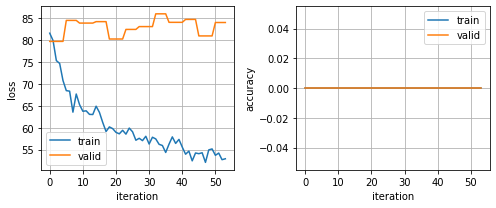

In [14]:
#come up with something better at some point
expanded_val_loss = []
expanded_val_acc = []
for i in range(len(loss_val)):
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_loss.append(loss_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    expanded_val_acc.append(acc_val[i])
    if i % 2 == 0:
        expanded_val_loss.append(loss_val[i])
        expanded_val_acc.append(acc_val[i])

plot_history(loss_train, acc_train, expanded_val_loss, expanded_val_acc)

In [15]:
file = open("/home/mvsnet/best results.txt", "w+")
file.write("train_acc: " + str(max(acc_train)) + "    index: " + str(np.argmax(acc_train)*300) + "\n")
file.write("val_acc: " + str(max(acc_val)) + "    index: " + str(np.argmax(acc_val)*300) + "\n")
file.close()

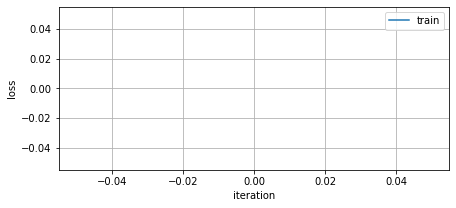

In [32]:
fig = plt.figure(figsize=(7, 3))
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(acc_train[0], label="train")
#plt.ylim()    
plt.legend()
plt.grid()

